In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal 
import scipy.fftpack
from pylab import *
from scipy import pi
import pylab
import cmath
import sys
import tensorflow as tf

print(tf.__version__)

2.5.0


## AE data analysis

In [13]:
data_path = "/media/a00439/2C167E66167E30C6/AEdata/20181203_1404_row005_feed300um_1_nor1/row005/"
# Import DATA
no = 62
url = data_path + "AEdate_"+str(no)+".lvm"

dt_loading = pd.read_fwf(url, widths=[10])[21:5000021] # samples : 4999168 (1024 * 4882) (2^22 = 4194304)
dt_tartype = np.array(dt_loading, dtype = np.float_) 
#ae_rawdata = pd.DataFrame(dt_tartype)#[0:4999168]
#ae_rawdata = dt_tartype.flatten()
ae_rawdata = dt_tartype.ravel()


In [21]:
# show the raw signal data
print(ae_rawdata[:10])
print(ae_rawdata[50000:50010])
waveform = tf.cast(ae_rawdata, tf.float32)
waveform = tf.reshape(waveform, [100, -1])
print(waveform.shape)
print(waveform[:2,:].numpy())
waveform = tf.transpose(waveform)
print(waveform.shape)
print(waveform[:,1].numpy())

[-0.383301 -0.302734 -0.117187 -0.004883 -0.009766 -0.109863 -0.231934
 -0.29541  -0.273437 -0.180664]
[-0.083008 -0.090332 -0.073242 -0.102539 -0.126953 -0.170898 -0.195312
 -0.192871 -0.153809 -0.109863]
(100, 50000)
[[-0.383301 -0.302734 -0.117187 ... -0.26123  -0.205078 -0.148926]
 [-0.083008 -0.090332 -0.073242 ... -0.537109 -0.214844  0.26123 ]]
(50000, 100)
[-0.083008 -0.090332 -0.073242 ... -0.537109 -0.214844  0.26123 ]


ae data sample rate :5000000


Text(0, 0.5, 'volt')

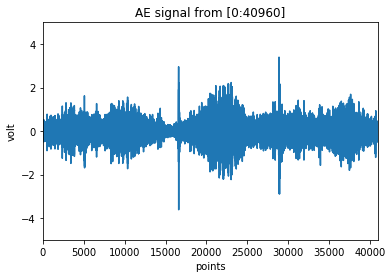

In [4]:
# show the raw signal plot
ae_data = ae_rawdata - ae_rawdata.mean()

sample_rate = len(ae_data)
print("ae data sample rate :{0}".format(sample_rate))

plt.plot(range(40960), ae_data[:40960])
plt.xlim(0,40960)
plt.ylim(-5,5)
plt.title("AE signal from [0:40960]")
plt.xlabel("points")
plt.ylabel("volt")

In [5]:
ae_max = np.max(np.abs(ae_data))
ae_min = np.min(np.abs(ae_data))
print("Maxima AE data: {0}".format(ae_max))
print("Minima AE data: {0}".format(ae_min))

Maxima AE data: 5.1520097613404
Minima AE data: 0.0006417613403998934


## STFT

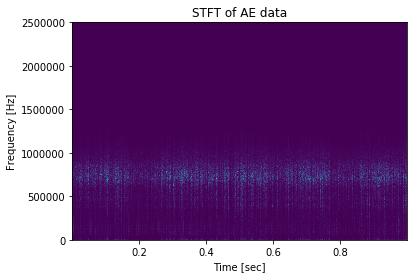

STFT factor shape f : (2049,)
STFT factor shape t : (2440,)
STFT factor shape Sxx : (2049, 2440)


In [6]:
window_size = 4096
[f,t,Sxx]=signal.spectral.spectrogram(x = ae_data[:],
                                    fs = sample_rate,
                                    window = np.hamming(window_size),
                                    nperseg = window_size,
                                    noverlap = window_size // 2,
                                    nfft = None,
                                    detrend = False,
                                    return_onesided = True,
                                    mode = 'magnitude')
# plt.pcolormesh(t, f, Sxx)
plt.pcolormesh(t, np.fft.fftshift(f), np.fft.fftshift(Sxx, axes=0))
plt.title("STFT of AE data")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

print("STFT factor shape f : {0}".format(shape(f)))
print("STFT factor shape t : {0}".format(shape(t)))
print("STFT factor shape Sxx : {0}".format(shape(Sxx)))

1024 point of frequency to AE STFT shape:  (1024, 2440)


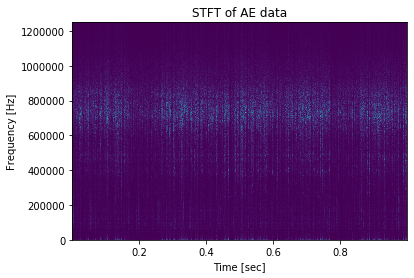

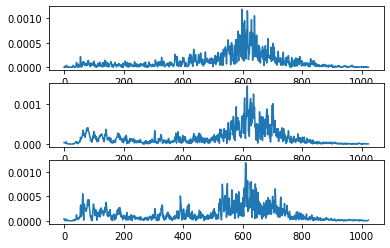

In [7]:
print('1024 point of frequency to AE STFT shape: ', format(Sxx[:1024].shape))
plt.pcolormesh(t,f[:1024],Sxx[:1024])
plt.title("STFT of AE data")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.figure()
plt.subplot(3,1,1)
plt.plot(Sxx[:1024,0])
plt.subplot(3,1,2)
plt.plot(Sxx[:1024,1])
plt.subplot(3,1,3)
plt.plot(Sxx[:1024,2])
plt.show()

In [8]:
# Normalization STFT coefficient
ae_stft_nor = Sxx / np.max(Sxx)

In [9]:
window_size = 4096
ae_ = ae_data.astype(float32)
stft = tf.signal.stft(
         ae_,
         window_size,
         frame_step=window_size//2,
         fft_length=None,
         window_fn=tf.signal.hann_window,
         pad_end=False,
         name=None
)
stft_ = stft[:,:1024]
stft_.shape


# plt.pcolormesh(t, np.fft.fftshift(f), np.fft.fftshift(Sxx, axes=0))
# plt.title("STFT of AE data")
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()

# print("STFT factor shape f : {0}".format(shape(f)))
# print("STFT factor shape t : {0}".format(shape(t)))
# print("STFT factor shape Sxx : {0}".format(shape(Sxx)))

TensorShape([2440, 1024])

In [110]:
# get AE data start date
dt_get_date = pd.read_fwf(url, widths=[20])[8:9]
dt_datetype = np.array(dt_get_date, dtype = np.str_)[0]
# print(dt_datetype[0][5:])
# get AE data start time
dt_get_time = pd.read_fwf(url, widths=[13])[14:15] # samples : 4999168 (1024 * 4882) (2^22 = 4194304)
dt_timetype = np.array(dt_get_time, dtype = np.str_)[0]
# print(dt_timetype[0][5:])

dt_start_datatime = dt_datetype[0][5:]+' '+ dt_timetype[0][5:]
print('data mask date and time : {0}'.format(dt_start_datatime))

data mask date and time : 2018/01/04 10:43:22


## Vibration data analysis

In [3]:
# Loading data from the file
data_path = "/media/yukun/2C167E66167E30C6/AE_data/20180104 正常砂輪研磨/第一次研磨(過負載)/"
num = 30

url = data_path + "/Current_"+str(num)+".lvm"
dt_loading = pd.read_fwf(url, widths=None, names=[])[23:-1]   # loading all data
df = np.array(dt_loading[0].str.split()).tolist()             # segemntation five data Curr1, Curr2, Curr3, Sd_ra, Sd_ax
df = np.array(df).ravel()
df = df.reshape(-1,5).astype(float)                           # reshape and transform type
print("data shape: {}".format((df).shape))
Curr_1 = df[:,0]
Curr_2 = df[:,1]
Curr_3 = df[:,2] 
Sd_ra = df[:,3]   # radial
Sd_ax = df[:,4]   # axial
Curr_1 = Curr_1 - Curr_1.mean()
Curr_2 = Curr_2 - Curr_2.mean()
Curr_3 = Curr_3 - Curr_3.mean()
Sd_ra = Sd_ra - Sd_ra.mean()
Sd_ax = Sd_ax - Sd_ax.mean()

data shape: (10000, 5)


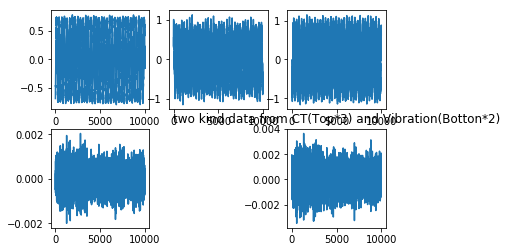

In [4]:
# plot the all data
plt.figure()
plt.subplot(2,3,1)
plt.plot(Curr_1)
plt.subplot(2,3,2)
plt.plot(Curr_2)
plt.subplot(2,3,3)
plt.plot(Curr_3)
plt.subplot(2,3,4)
plt.plot(Sd_ra)
plt.subplot(2,3,6)
plt.plot(Sd_ax)
# plt.xticks([])
# plt.yticks([])
plt.title("two kind data from CT(Top*3) and Vibration(Botton*2)")
plt.show()

STFT shape: (129, 77)
t shape: (77,)
f shape: (129,)


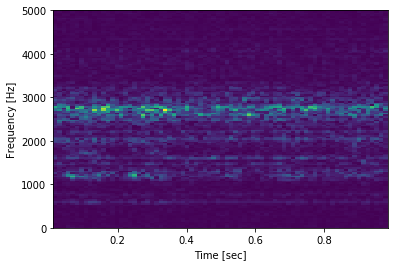

In [6]:
# plot the STFT of Vibration data of the radial spindle
vib_sample_rate = 10000
vib_window_size = 256

[f,t,Sd_ra_stft]=signal.spectral.spectrogram(x = Sd_ra,
                                    fs = vib_sample_rate,
                                    window = np.hamming(vib_window_size),
                                    nperseg = vib_window_size,
                                    noverlap = vib_window_size // 2,
                                    nfft = None,
                                    detrend = False,
                                    return_onesided = True,
                                    mode = 'magnitude')

print("STFT shape: {}".format(Sd_ra_stft.shape))
print("t shape: {}".format(t.shape))
print("f shape: {}".format(f.shape))
plt.pcolormesh(t, f, Sd_ra_stft)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

STFT shape: (513, 18)
t shape: (18,)
f shape: (513,)


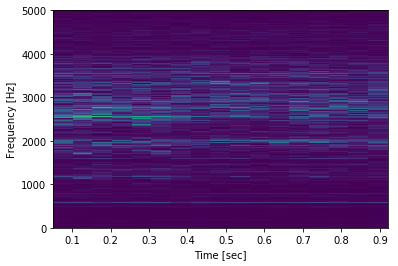

In [26]:
# plot the STFT of Vibration data of the axial spindle
[f,t,Sd_ax_stft]=signal.spectral.spectrogram(x = Sd_ax,
                                    fs = vib_sample_rate,
                                    window = np.hamming(vib_window_size),
                                    nperseg = vib_window_size,
                                    noverlap = vib_window_size // 2,
                                    nfft = None,
                                    detrend = False,
                                    return_onesided = True,
                                    mode = 'magnitude')

print("STFT shape: {}".format(Sd_ax_stft.shape))
print("t shape: {}".format(t.shape))
print("f shape: {}".format(f.shape))
plt.pcolormesh(t, f, Sd_ax_stft)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
# Normalization AE STFT
Sd_ra_stft_nor = Sd_ra_stft / np.max(Sd_ra_stft)
Sd_ax_stft_nor = Sd_ax_stft / np.max(Sd_ax_stft)

In [7]:
csv_file

'/media/yukun/2C167E66167E30C6/AE_data/20180104 正常砂輪研磨/第一次研磨(過負載)//20180104_104852 設備參數.csv'

## Load the Equipment data from .CSV file 

In [8]:
# Load .csv   Time	10:43:17
csv_file = data_path + "/20180104_104852 設備參數.csv"
gapminder = pd.read_csv(csv_file, header=None)  
select_df = pd.DataFrame(gapminder)
# print(select_df)
# select_df.iloc[10]  # 讀取第 x row的所有資料
select_df.columns = ['Num','SetSpindle','SetWorkAxis','FreeAxis','Nan','SpindleLoad','RealSpindle','','RealWorkAxis',\
                     '','Zposition','Thickness','Time','mark']

mask1 = select_df['Time'] >= "2018/01/04 10:43:17"
df_mask = select_df[mask1]                             # 濾除不需要的資料，保留符合條件的資料

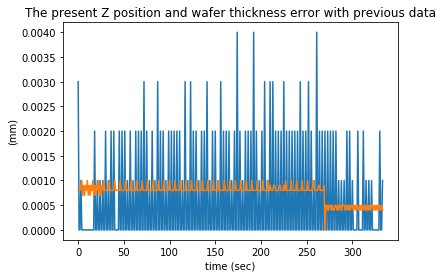

In [9]:
T1 = select_df.loc[df_mask.index[0]:,'Thickness']  # select 'Thickness' columns from 367:
T2 = select_df.loc[df_mask.index[1]:,'Thickness']
T1.index = range(len(T1.index))       # RangeIndex(start=0, stop=335, step=1)
T2.index = range(len(T2.index))
Z_pos1 = select_df.loc[df_mask.index[0]:,'Zposition']  # select 'Z position' columns from 367:
Z_pos2 = select_df.loc[df_mask.index[1]:,'Zposition']
Z_pos1.index = range(len(Z_pos1.index))       # RangeIndex(start=0, stop=335, step=1)
Z_pos2.index = range(len(Z_pos2.index))

# print('T1 length: {}'.format(len(T1[:-1])))
# print('T2 length: {}'.format(len(T2[:])))
error = T1[:-1] - T2[:]                       # workpiece tinckness error
error.loc[error<0] = 0
plt.plot(error)

# print('Z1 length: {}'.format(len(Z_pos1[:-1])))
# print('Z2 length: {}'.format(len(Z_pos2[:])))
z_pos_error = Z_pos1[:-1] - Z_pos2[:]         # z positon error
z_pos_error.loc[z_pos_error<0] = 0
plt.plot(z_pos_error)
plt.title("The present Z position and wafer thickness error with previous data")
plt.xlabel("time (sec)")
plt.ylabel("(mm)")
plt.show()

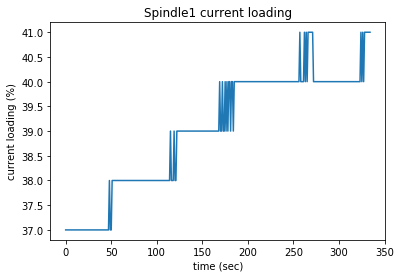

In [34]:
s1_current1 = select_df.loc[df_mask.index[0]:,'SpindleLoad']
s1_current1.index = range(len(s1_current1.index))
plt.plot(s1_current1)
plt.title("Spindle1 current loading")
plt.xlabel("time (sec)")
plt.ylabel("current loading (%)")
plt.show()

In [ ]:
class data_transform_stft(file_path, data_num):
    def __init__
    
    
    return ae_stft, Sd_ra_stft_nor, Sd_ax_stft_nor